purpose of this notebook is to finetune the "distilbert/distilbert-base-uncased" model
Handles city, state and city-state separately

In [1]:
import pandas as pd
from datasets import Dataset, DatasetDict
import evaluate
import numpy as np
from transformers import AutoTokenizer
from transformers import AutoModelForTokenClassification, TrainingArguments, Trainer
from peft import get_peft_model, LoraConfig, TaskType
from transformers import TrainingArguments, Trainer

/home/jupyter/new_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from torch import cuda
device = 'cuda' if cuda.is_available() else 'mps'
print(device)

cuda


In [3]:
# full_dataset = Dataset.from_parquet("data/combined_ner_examples.parquet")
# full_dataset = Dataset.from_parquet("data/combined_ner_examples_v2.parquet")
# full_dataset = Dataset.from_parquet("data/combined_ner_examples_v3.parquet")
# full_dataset = Dataset.from_parquet("data/synthetic_loc_dataset.parquet")
# full_dataset = Dataset.from_parquet("data/synthetic_loc_dataset_v2.parquet")
# full_dataset = Dataset.from_parquet("data/synthetic_loc_dataset_v3.parquet")
full_dataset = Dataset.from_parquet("data/synthetic_loc_dataset_v4.parquet")


Generating train split: 400000 examples [00:00, 1201777.03 examples/s]


In [4]:
full_dataset

Dataset({
    features: ['tokens', 'ner_tags', 'id'],
    num_rows: 400000
})

In [5]:
val_set_size = 5000
val_start = len(full_dataset) - val_set_size
val_start

395000

In [6]:


# Split the dataset into train and validation sets
train_dataset = full_dataset.select(range(val_start))  # Select training rows
val_dataset = full_dataset.select(range(val_start, len(full_dataset)))  # Select last 1000 rows for validation

# Combine them into a DatasetDict
dataset = DatasetDict({
    'train': train_dataset,
    'validation': val_dataset
})

In [7]:
dataset

DatasetDict({
    train: Dataset({
        features: ['tokens', 'ner_tags', 'id'],
        num_rows: 395000
    })
    validation: Dataset({
        features: ['tokens', 'ner_tags', 'id'],
        num_rows: 5000
    })
})

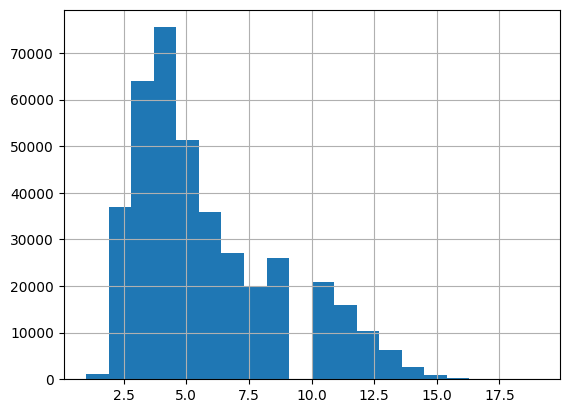

In [8]:
dataset['train'].to_pandas()['tokens'].apply(len).hist(bins=20);

In [9]:
from transformers import AutoTokenizer

# Load the tokenizer for distilbert-based NER
tokenizer = AutoTokenizer.from_pretrained("distilbert/distilbert-base-uncased")

# Function to tokenize the input and align labels with tokens
def tokenize_and_align_labels(example):
    # Tokenize 'tokens' while keeping track of word boundaries
    tokenized_inputs = tokenizer(
        example['tokens'], 
        is_split_into_words=True, 
        truncation=True, 
        padding='max_length',
        max_length=64,
    )
    
    # Get the word_ids (mapping from tokens to original words)
    word_ids = tokenized_inputs.word_ids()
    aligned_labels = []

    previous_word_idx = None
    for word_idx in word_ids:
        if word_idx is None:
            aligned_labels.append(-100)  # Special tokens ([CLS], [SEP], etc.)
        elif word_idx != previous_word_idx:
            aligned_labels.append(example['ner_tags'][word_idx])  # Assign the label to the first token of each word
        else:
            aligned_labels.append(-100)  # Subword tokens get label -100

        previous_word_idx = word_idx

    tokenized_inputs["labels"] = aligned_labels
    return tokenized_inputs

# Apply the function to the dataset
tokenized_dataset = dataset.map(tokenize_and_align_labels)



/home/jupyter/new_env/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Map: 100%|██████████| 5000/5000 [00:01<00:00, 3874.64 examples/s]


In [10]:
tokenized_dataset

DatasetDict({
    train: Dataset({
        features: ['tokens', 'ner_tags', 'id', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 395000
    })
    validation: Dataset({
        features: ['tokens', 'ner_tags', 'id', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 5000
    })
})

In [11]:
tokenized_dataset['validation'][0]

{'tokens': ['soups', 'in', 'Nevada'],
 'ner_tags': [0, 0, 7],
 'id': 395000,
 'input_ids': [101,
  11350,
  2015,
  1999,
  7756,
  102,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 'attention_mask': [1,
  1,
  1,
  1,
  1,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 'labels': [-100,
  0,
  -100,
  0,
  7,
  -100,
  -100,
  -100,
  -100,
  -100,
  -100,
  -100,
  -100,
  -100,
  -100,
  -100,
  -100,
  -100,
  -100,
  -100,
  -100,
  -100,
  -100,
  -100,
  -100,
  -100,
  -100,
  -100,
  -100,


In [12]:
def postprocess_predictions_and_labels(predictions, references):
    true_predictions = []
    true_labels = []
    cmp_count = 0

    for prediction, reference in zip(predictions, references):
        # Only keep labels that are not -100
        true_labels_example = [label for label in reference if label != -100]
        
        # Align predictions: Remove predictions for which the corresponding reference label is -100
        true_predictions_example = [pred for pred, ref in zip(prediction, reference) if ref != -100]

        # Ensure the length of predictions and labels matches
        if len(true_predictions_example) == len(true_labels_example):
            true_labels.append(true_labels_example)
            true_predictions.append(true_predictions_example)
            cmp_count += 1
        else:
            # Log or handle the error (example-level mismatch)
            # print(f"Skipping example due to mismatch: predictions ({len(true_predictions_example)}), labels ({len(true_labels_example)})")
            continue  # Skip this example

    # Flatten the lists (convert from list of lists to a single list)
    true_predictions = [pred for sublist in true_predictions for pred in sublist]
    true_labels = [label for sublist in true_labels for label in sublist]
    print(f"cmp_count = {cmp_count} out of {len(predictions)}")

    return true_predictions, true_labels


In [13]:
def compute_metrics(p):
    logits, labels = p
    predictions = np.argmax(logits, axis=1)
    
    # Post-process the predictions and labels to remove -100 values
    true_predictions, true_labels = postprocess_predictions_and_labels(predictions, labels)

    # Combine metrics
    accuracy_metric = evaluate.load("accuracy")
    precision_metric = evaluate.load("precision")
    recall_metric = evaluate.load("recall")
    f1_metric = evaluate.load("f1")

    # Calculate metrics
    accuracy = accuracy_metric.compute(predictions=true_predictions, references=true_labels)
    precision = precision_metric.compute(predictions=true_predictions, references=true_labels, average="weighted")
    recall = recall_metric.compute(predictions=true_predictions, references=true_labels, average="weighted")
    f1 = f1_metric.compute(predictions=true_predictions, references=true_labels, average="weighted")

    return {
        "accuracy": accuracy["accuracy"],
        "precision": precision["precision"],
        "recall": recall["recall"],
        "f1": f1["f1"]
    }

In [14]:
# Define the NER label mappings
# id2label = {
#     0: "O",         # Outside any entity
#     1: "B-PER",     # Beginning of a person entity
#     2: "I-PER",     # Inside a person entity
#     3: "B-ORG",     # Beginning of an organization entity
#     4: "I-ORG",     # Inside an organization entity
#     5: "B-LOC",     # Beginning of a location entity
#     6: "I-LOC",     # Inside a location entity
#     7: "B-MISC",    # Beginning of a miscellaneous entity
#     8: "I-MISC"     # Inside a miscellaneous entity
# }

id2label = {
    0: "O",        # Outside any named entity
    1: "B-PER",    # Beginning of a person entity
    2: "I-PER",    # Inside a person entity
    3: "B-ORG",    # Beginning of an organization entity
    4: "I-ORG",    # Inside an organization entity
    5: "B-CITY",    # Beginning of a city entity
    6: "I-CITY",    # Inside a city entity
    7: "B-STATE",    # Beginning of a state entity
    8: "I-STATE",    # Inside a state entity
    9: "B-CITYSTATE",   # Beginning of a city_state entity
   10: "I-CITYSTATE",   # Inside a city_state entity
}

label2id = {v: k for k, v in id2label.items()}

# Load the pre-trained model
model = AutoModelForTokenClassification.from_pretrained("distilbert/distilbert-base-uncased", 
                                                        num_labels=11, 
                                                        id2label=id2label, 
                                                        label2id=label2id)

# Define the LoRA configuration
lora_config = LoraConfig(
    task_type=TaskType.TOKEN_CLS,  # Task type is token classification (NER)
    r=16,  # Low-rank dimension (you can experiment with this)
    lora_alpha=32,  # Scaling factor for LoRA
    lora_dropout=0.1,  # Dropout rate for LoRA
    target_modules=['q_lin', 'k_lin']  # LoRA is applied to query layer
)

# Apply LoRA to the model
lora_model = get_peft_model(model, lora_config)


Some weights of DistilBertForTokenClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [15]:
lora_model.print_trainable_parameters()

trainable params: 303,371 || all params: 66,674,710 || trainable%: 0.4550


In [16]:
# lora_model

In [ ]:


# Define the training arguments
training_args = TrainingArguments(
    output_dir="./results",           # Output directory
    evaluation_strategy="epoch",      # Evaluate at the end of every epoch
    learning_rate=2e-5,               # Learning rate
    per_device_train_batch_size=16,   # Batch size for training
    per_device_eval_batch_size=16,    # Batch size for evaluation
    num_train_epochs=6,               # Number of training epochs
    weight_decay=0.01,                # Weight decay
    logging_dir='./logs',             # Directory for logging
)

# Initialize the Trainer
trainer = Trainer(
    model=lora_model,                  # LoRA-wrapped model
    args=training_args,                # Training arguments
    train_dataset=tokenized_dataset['train'],  # Training dataset
    eval_dataset=tokenized_dataset["validation"],  # Validation dataset (if available)
    tokenizer=tokenizer,               # Tokenizer
    compute_metrics=compute_metrics,  # model perfomance evaluation metric
)

# Fine-tune the model
trainer.train()


/home/jupyter/new_env/lib/python3.10/site-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.024400,0.013284,0.084216,0.490154,0.084216,0.091639
2,0.014800,0.005224,0.083119,0.507702,0.083119,0.090871
3,0.010700,0.003312,0.075961,0.510936,0.075961,0.079411
4,0.007800,0.002657,0.080542,0.501463,0.080542,0.090567
5,0.007900,0.002374,0.075818,0.506821,0.075818,0.082395
6,0.008400,0.002244,0.075150,0.506318,0.075150,0.080811


cmp_count = 4075 out of 5000


/home/jupyter/new_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


cmp_count = 4075 out of 5000


/home/jupyter/new_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


cmp_count = 4075 out of 5000


/home/jupyter/new_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


cmp_count = 4075 out of 5000


/home/jupyter/new_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


cmp_count = 4075 out of 5000


/home/jupyter/new_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


cmp_count = 4075 out of 5000


/home/jupyter/new_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


TrainOutput(global_step=148128, training_loss=0.029309118492901003, metrics={'train_runtime': 9130.7796, 'train_samples_per_second': 259.562, 'train_steps_per_second': 16.223, 'total_flos': 3.898837142784e+16, 'train_loss': 0.029309118492901003, 'epoch': 6.0})

In [18]:
import torch
from transformers import AutoTokenizer

# Your text list
text_list = [
    'New York', 'Los Angeles', 'Chicago', 'Philadelphia', 'Dallas',
    'Fort Worth', 'Houston', 'Atlanta', 'Boston', 'Manchester',
    'Washington, D.C.', 'Hagerstown', 'San Francisco', 'Oakland',
    'San Jose', 
    'san jose',
    'weather in san jose',
    'weather in Boston',
    'Weather in Boston',
    'weather Boston',
    'Weather Boston',
    'weather',
    'Weather',
    'Boston weather',
    'Boston Weather',
    'I love Pizzahut',
    'I like Starbucks',
    'sushi restaurants in Sunnyvale, CA',
    'sushi restaurants in Sunnyvale, California',
    'ramen in sf',
    'sushi sf',
    'sushi sfo',
    'sushi sfo, CA',
    'ramen sfo',
    'sfo sushi',
    'phx ramen',
    'restaurants seattle',
    'restaurants in seattle',
    'restaurants near seattle',
    'seattle restaurants',
    'seattle wa restaurants',
    'seattle, wa restaurants',
    'waterloo ia hamburgers',
    'walm',
    'footbal',
    'ramen ra',
    'big city',
    'orlando bloom', 
    'banana', 
    'lenght',
    'restaurants in abcid',
    'allien', 'proposa', 'wather',
    'orlando realty group',
    
]

model = trainer.model


# Function to make predictions and group entities
def predict_ner(text_list):
    model.eval()  # Set the model to evaluation mode

    for text in text_list:
        # Tokenize the input text
        inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True)
        
        # Move inputs to the same device as the model
        inputs = {k: v.to(model.device) for k, v in inputs.items()}
        
        # Perform inference
        with torch.no_grad():
            outputs = model(**inputs)
        
        # Get predictions (logits -> predicted labels)
        predictions = torch.argmax(outputs.logits, dim=-1).cpu().numpy()[0]
        
        # Map the predictions to labels and tokens
        tokens = tokenizer.convert_ids_to_tokens(inputs['input_ids'][0].cpu().numpy())
        ner_labels = [model.config.id2label[pred] for pred in predictions]

        # Group tokens back into entities
        current_entity = []
        current_label = None
        entities = []

        for token, label in zip(tokens, ner_labels):
            print(token, label)
            # Ignore special tokens like [CLS], [SEP]
            if token in ["[CLS]", "[SEP]"]:
                continue
            # Handle subword tokens (tokens starting with ##)
            if token.startswith("##"):
                if current_entity:
                    current_entity[-1] += token[2:]  # Append the subword without "##"
            elif label.startswith("B-") or (label.startswith("I-") and label != current_label):
                # New entity starts, append the old one
                if current_entity:
                    entities.append(" ".join(current_entity))
                    current_entity = []
                current_entity.append(token)
                current_label = label
            elif label.startswith("I-") and label == current_label:
                # Continue current entity
                current_entity.append(token)
            else:
                # Non-entity token or 'O'
                if current_entity:
                    entities.append(" ".join(current_entity))
                    current_entity = []
                current_label = None

        # Append any remaining entity
        if current_entity:
            entities.append(" ".join(current_entity))

        # Clean up tokens (remove subword tokens and punctuation issues, etc.)
        clean_entities = []
        for entity in entities:
            entity = entity.replace(" ##", " ")
            entity = entity.replace(" .", ".")  # Handle punctuation
            entity = entity.replace(" ,", ",")
            clean_entities.append(entity)

        # Print the result for comparison
        print(f"Input: {text}")
        print(f"Predicted entities: {' '.join(clean_entities)}")
        print()

# Run predictions on the text list
predict_ner(text_list)


[CLS] O
new B-STATE
york I-STATE
[SEP] O
Input: New York
Predicted entities: new york

[CLS] O
los B-CITY
angeles I-CITY
[SEP] O
Input: Los Angeles
Predicted entities: los angeles

[CLS] O
chicago B-CITY
[SEP] O
Input: Chicago
Predicted entities: chicago

[CLS] O
philadelphia B-CITY
[SEP] O
Input: Philadelphia
Predicted entities: philadelphia

[CLS] O
dallas B-CITY
[SEP] O
Input: Dallas
Predicted entities: dallas

[CLS] O
fort B-CITY
worth I-CITY
[SEP] O
Input: Fort Worth
Predicted entities: fort worth

[CLS] O
houston B-CITY
[SEP] O
Input: Houston
Predicted entities: houston

[CLS] O
atlanta B-CITY
[SEP] O
Input: Atlanta
Predicted entities: atlanta

[CLS] O
boston B-CITY
[SEP] O
Input: Boston
Predicted entities: boston

[CLS] O
manchester B-CITY
[SEP] O
Input: Manchester
Predicted entities: manchester

[CLS] O
washington B-CITYSTATE
, I-CITYSTATE
d I-CITYSTATE
. I-CITYSTATE
c I-CITYSTATE
. I-CITY
[SEP] O
Input: Washington, D.C.
Predicted entities: washington , d. c .

[CLS] O
ha B-CIT

In [19]:
from transformers import AutoModelForTokenClassification, AutoTokenizer
from peft import PeftModel, PeftConfig

# Load the base model (DistilBERT NER model)
base_model = AutoModelForTokenClassification.from_pretrained("distilbert/distilbert-base-uncased",
                                                             num_labels=11,
                                                             id2label=id2label,
                                                             label2id=label2id)

# Load the tokenizer
tokenizer = AutoTokenizer.from_pretrained("distilbert/distilbert-base-uncased")

# Load the LoRA-adapted model
peft_config = PeftConfig.from_pretrained("results/checkpoint-148128")
lora_model = PeftModel.from_pretrained(base_model, "results/checkpoint-148128")

# Merge the LoRA weights with the base model
merged_model = lora_model.merge_and_unload()  # This merges LoRA into the base model


Some weights of DistilBertForTokenClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/jupyter/new_env/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [20]:
# Save the merged model and tokenizer
save_dir = "tmp/merged_distilbert_uncased_ner"
merged_model.save_pretrained(save_dir)
tokenizer.save_pretrained(save_dir)

('tmp/merged_distilbert_uncased_ner/tokenizer_config.json',
 'tmp/merged_distilbert_uncased_ner/special_tokens_map.json',
 'tmp/merged_distilbert_uncased_ner/vocab.txt',
 'tmp/merged_distilbert_uncased_ner/added_tokens.json',
 'tmp/merged_distilbert_uncased_ner/tokenizer.json')

In [21]:
# !huggingface-cli whoami

In [22]:
# !huggingface-cli login

In [24]:
# Upload the merged model
merged_model_dir = "tmp/merged_distilbert_uncased_ner"
merged_repo_id = "Mozilla/distilbert-uncased-NER-LoRA" 

merged_model.push_to_hub(merged_repo_id)
tokenizer.push_to_hub(merged_repo_id)


model.safetensors: 100%|██████████| 265M/265M [00:06<00:00, 39.8MB/s] 


CommitInfo(commit_url='https://huggingface.co/Mozilla/distilbert-uncased-NER-LoRA/commit/2767ead387ed789f27076df6f51978cdf9a1b463', commit_message='Upload tokenizer', commit_description='', oid='2767ead387ed789f27076df6f51978cdf9a1b463', pr_url=None, repo_url=RepoUrl('https://huggingface.co/Mozilla/distilbert-uncased-NER-LoRA', endpoint='https://huggingface.co', repo_type='model', repo_id='Mozilla/distilbert-uncased-NER-LoRA'), pr_revision=None, pr_num=None)